## Imports

In [368]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from scipy.io import wavfile # get the api
from pynq import Overlay 
import wave

## Define functions for getting wav data

In [369]:
def get_num_samples(wav):
    return wav.getnframes()
def get_num_channels(wav):
    return wav.getnchannels()
def get_sampling_frequency(wav):
    return wav.getframerate()
def get_duration(wav):
    return (get_num_samples(wav)/get_sampling_frequency(wav))
def get_bytes_per_sample(wav):
    return wav.getnchannels()
def print_wav_info(wav):
    #Print number of samples
    print("Number of samples", get_num_channels(wav))
    #Print number of channels (1--mono, 2--stereo)
    num_channels = wav.getnchannels()
    print("Number of channels", num_channels)
    #Print sampling frequency
    sampFreq = wav.getframerate()
    print("Sampling Frequency", sampFreq)
    #Print duration of file
    print("Duration of file (in s) ", get_duration(wav))
    #Print byte depth of audio (8-bit, 16-bit, etc.)
    print("bytes per sample", get_bytes_per_sample(wav))



## Get samples from wav file and plot sound data

Number of samples 2
Number of channels 2
Sampling Frequency 44100
Duration of file (in s)  5.616326530612245
bytes per sample 2


<IPython.core.display.Javascript object>


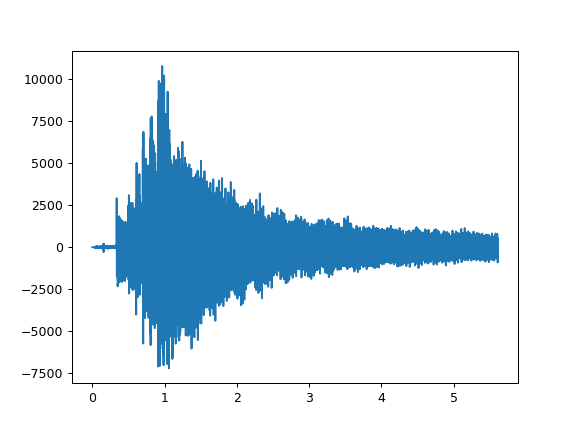

In [370]:
#This wav file consists of notes: E, B, G# -- corresponding to frequencies(in Hz): 82, 123, 208 
E7_chord = "E7_chord.wav"
#This wav file consist of one note: E -- corresponding to frequency(in Hz): 82
E_note = "lowE.wav"

#The following notebook can use either sound file -- try uncommenting either line to see the
#differences between their frequency spectrums
soundFile = E7_chord
#soundFile = E_note

#Open selected sound file and print metadata
wav = wave.open(soundFile)
print_wav_info(wav)

#Read samples into numpy array for easier manipulation
sampFreq, data = wavfile.read(soundFile)

#Get duration and number of samples
wav_duration = get_duration(wav)
num_samples = get_num_samples(wav)
#Create time axis to plot against sound data
t = np.linspace(0, wav_duration, num_samples)
#If stereo, convert to mono
if (get_num_channels(wav) == 2):
    data = data[:,0]

#Plot
fig, ax = plt.subplots() 
plt.plot(t, data)

## Define FFT functions

In [371]:
def get_FFT(data):
    #Only want real frequencies
    spectrum = np.fft.rfft(data)
    #Only want magnitude (intensity)
    abs_spectrum = np.abs(spectrum)
    return abs_spectrum

def get_frequency_vector(data, Fs):
    return np.fft.rfftfreq(data.size, d=1./Fs)

def get_frequency_window(samplingFrequency, freq_vector, max_desired_frequency):    
    max_given_frequency = samplingFrequency/2
    frequency_vector_length = len(freq_vector)
    
    if max_given_frequency < max_desired_frequency:
        print("Cannot plot desired window -- max frequency is ", max_given_frequency)
        return frequency_vector_length
    else:
        print("Cropping frequency window from available max ", max_given_frequency, "to desired max", max_desired_frequency)
        

    window_fraction = max_desired_frequency / max_given_frequency
    window = int(window_fraction * frequency_vector_length)
    return window
def plot_notebook(x, y, window):
    %matplotlib notebook
    fig, ax = plt.subplots()  # Create a figure containing a single axes.
    ax.plot(x[:window], y[:window])  # Plot some data on the axes.
def plot_fft(data):
    #Perform FFT on wav samples
    fft_spectrum_abs = get_FFT(data)

    #Generate frequency vector for plotting 
    freq = get_frequency_vector(data, sampFreq)
    
    #Calculates how many samples to display in order to see spectrum from [0, 500] Hz
    window = get_frequency_window(sampFreq, freq)
    
    fig, ax = plt.subplots()  # Create a figure containing a single axes.
    ax.plot(freq[:window], fft_spectrum_abs[:window])  # Plot some data on the axes.
def sample_wav_data(data, sampFreq, t0, t1, num_samples_desired):
    time_window = t1 - t0
    start_sample = t0 * sampFreq
    end_sample = t1 * sampFreq
    sample_window = end_sample - start_sample
    #Calculate space between selected wav samples
    stepSize = int(sample_window / num_samples_desired)
    #Create empty array to hold sampled data
    sampledData = np.zeros(num_samples_desired)
    
    #Fill sampled data array with "num_samples_desired" samples from wav file, spaced by "stepSize"
    for i in range(0, num_samples_desired):
        sampledData[i] = data[start_sample+(i*stepSize)]
    numSamplesObtained=len(sampledData)

    wav_sample_range = numSamplesObtained * stepSize
    wav_time_range = wav_sample_range / sampFreq
    newsampFreq = numSamplesObtained / wav_time_range
    
    print("Maximum frequency to be plotted is ", newsampFreq/2)
    
    return sampledData, newsampFreq


## Plot SW FFT based on wav-given Fs

Cropping frequency window from available max  22050.0 to desired max 500


<IPython.core.display.Javascript object>


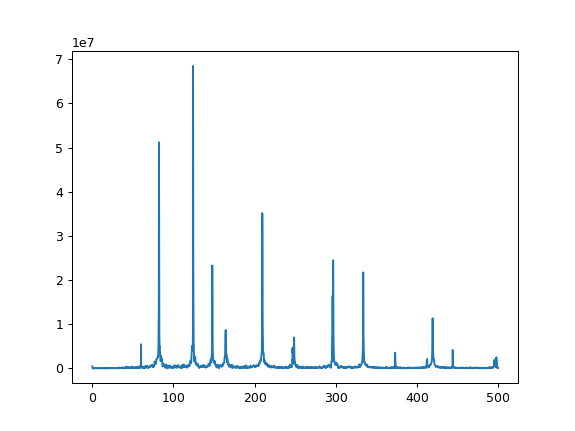

In [372]:
#Perform FFT on wav samples
fft_spectrum_abs = get_FFT(data)

#Generate frequency vector for plotting 
freq = get_frequency_vector(data, sampFreq)

#Calculates how many samples to display in order to see spectrum from [0, window_max]
window_max = 500
window = get_frequency_window(sampFreq, freq, window_max)

#Plot
plot_notebook(freq, fft_spectrum_abs, window)

In [373]:
#Create time and sample window
t0 = 0
t1 = 1
#t1 = wav_duration
numSamplesDesired = 2048

sampledData, newsampFreq = sample_wav_data(data, sampFreq, t0, t1, numSamplesDesired)

Maximum frequency to be plotted is  1050.0


## Sample data

1000 loops, best of 3: 893 µs per loop
Cropping frequency window from available max  1050.0 to desired max 500


<IPython.core.display.Javascript object>


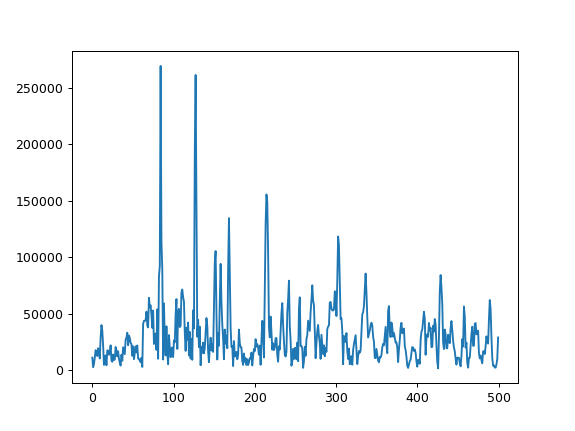

In [365]:
%timeit sampled_FFT_spectrum = get_FFT(sampledData)
sampled_frequency_vector = get_frequency_vector(sampledData, newsampFreq)
window_max = 500
window = get_frequency_window(newsampFreq, freq, window_max)
plot_notebook(sampled_frequency_vector, sampled_FFT_spectrum, window)

# HW FFT with 1024 samples


In [375]:
from pynq import allocate
from pynq import Overlay

In [376]:
def hw_fft_postprocess(hw_output):
    #Only want to plot magnitude of hardware output
    fft_data = np.abs(hw_output)
    #Only interested in plotting positive frequencies
    max_pos_freq_index = len(fft_data) // 2 + 1
    pos_fft_data = fft_data[0:max_pos_freq_index]
    return pos_fft_data

In [377]:
overlay = Overlay("fft_1024.bit")
dma = overlay.fft_hier.axi_dma_0

In [378]:
t0 = 0
t1 = 1
fft_size = 1024

sampledData, newsampFreq_1024 = sample_wav_data(data, sampFreq, t0, t1, fft_size)



Maximum frequency to be plotted is  512.7906976744185


In [379]:
input_buffer = allocate((fft_size,), np.csingle)
output_buffer = allocate((fft_size,), np.csingle)

np.copyto(input_buffer, sampledData)

In [380]:
def run_kernel():
    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [381]:
%timeit run_kernel()

1000 loops, best of 3: 602 µs per loop


Cropping frequency window from available max  512.7906976744185 to desired max 500


<IPython.core.display.Javascript object>


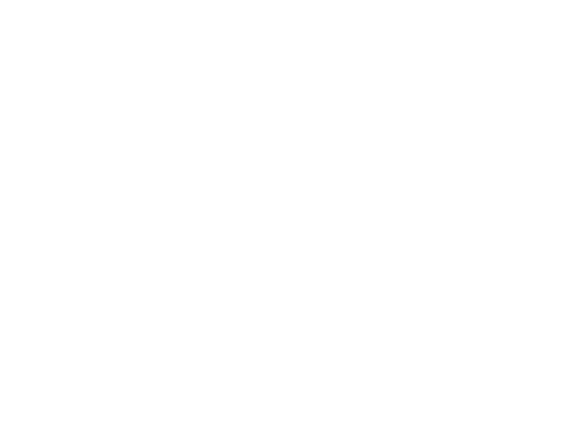

In [382]:
fft_data_1024 = hw_fft_postprocess(output_buffer)
freq = get_frequency_vector(output_buffer, newsampFreq_1024)
window_max = 500
window = get_frequency_window(newsampFreq_1024, freq, window_max)

plot_notebook(freq, fft_data_1024, window_max)

# HW FFT with 2048 samples


In [383]:
from pynq import allocate
from pynq import Overlay

In [384]:
def hw_fft_postprocess(hw_output):
    #Only want to plot magnitude of hardware output
    fft_data = np.abs(hw_output)
    #Only interested in plotting positive frequencies
    max_pos_freq_index = len(fft_data) // 2 + 1
    pos_fft_data = fft_data[0:max_pos_freq_index]
    return pos_fft_data

In [385]:
overlay = Overlay("fft_2048.bit")
dma = overlay.fft_hier.axi_dma_0

In [386]:
t0 = 0
t1 = 1
fft_size = 2048

sampledData, newsampFreq_2048 = sample_wav_data(data, sampFreq, t0, t1, fft_size)


Maximum frequency to be plotted is  1050.0


In [387]:
input_buffer = allocate((fft_size,), np.csingle)
output_buffer = allocate((fft_size,), np.csingle)

np.copyto(input_buffer, sampledData)

In [388]:
def run_kernel():
    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [389]:
%timeit run_kernel()

1000 loops, best of 3: 713 µs per loop


Cropping frequency window from available max  1050.0 to desired max 500


<IPython.core.display.Javascript object>


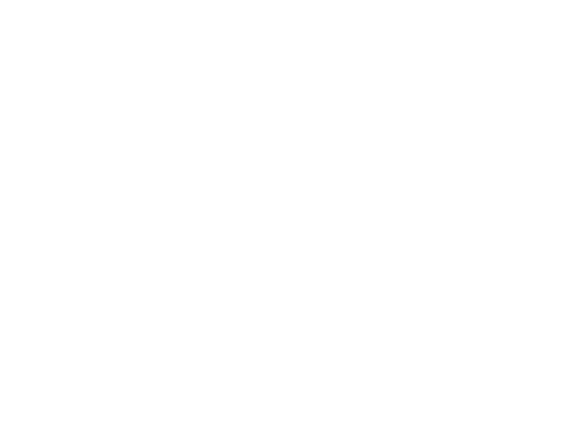

In [390]:
fft_data_2048 = hw_fft_postprocess(output_buffer)
freq = get_frequency_vector(output_buffer, newsampFreq_2048)
window_max = 500
window = get_frequency_window(newsampFreq_2048, freq, window_max)

plot_notebook(freq, fft_data_2048, window_max)

# HW FFT with 16384 samples

In [398]:
from pynq import allocate
from pynq import Overlay

In [399]:
overlay = Overlay("fft_16384.bit")
dma = overlay.fft_hier.axi_dma_0

In [400]:
t0 = 0
t1 = 2
fft_size = 16384

sampledData, newsampFreq_16384 = sample_wav_data(data, sampFreq, t0, t1, fft_size)


Maximum frequency to be plotted is  4410.0


In [401]:
input_buffer = allocate((fft_size,), np.csingle)
output_buffer = allocate((fft_size,), np.csingle)
np.copyto(input_buffer, sampledData)

In [402]:
def run_kernel():
    dma.sendchannel.transfer(input_buffer)
    dma.recvchannel.transfer(output_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [405]:
%timeit run_kernel()

100 loops, best of 3: 3.93 ms per loop


Cropping frequency window from available max  4410.0 to desired max 500


<IPython.core.display.Javascript object>


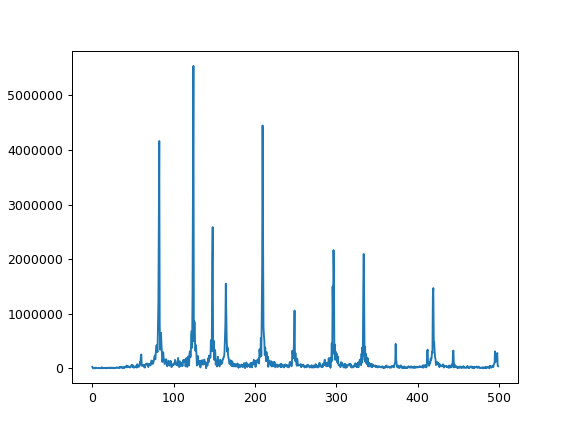

In [406]:
fft_data_16384 = hw_fft_postprocess(output_buffer)
freq = get_frequency_vector(output_buffer, newsampFreq_16384)
window_max = 500
window = get_frequency_window(newsampFreq_16384, freq, window_max)

plot_notebook(freq, fft_data_16384, window)

## Find max frequency -- Integrating with David Boullie's HLS 

In [330]:
from pynq import allocate
from pynq import Overlay

In [331]:
#New IP -- gives zeroes
#max_overlay = Overlay("top_freq.bit")
#max_ip = max_overlay.get_top_freq_0
#max_dma = max_overlay.axi_dma_0

#Old IP -- assumes 1024 Hz sampling frequency
max_overlay = Overlay("maxValue2.bit")
max_ip = max_overlay.max_DMA.get_top_freq_0
max_dma = max_overlay.max_DMA.axi_dma_0

In [333]:
#If type is numpy.complex64, 64 bit (8-byte) complex float
#DMA transfer size is (8*len(max_buffer)) bytes

#Operate on 1024-sample FFT data
#max_buffer = allocate(len(fft_data_1024), np.csingle)
#max_buffer[:] = fft_data_1024[:]

#Operate on 2048-sample FFT data
max_buffer = allocate(len(fft_data_2048), np.csingle)
max_buffer[:] = fft_data_2048[:]
print(len(max_buffer))

#Operate on 16384-sample FFT data
#max_buffer = allocate(len(fft_data_16384), np.csingle)
#max_buffer[:] = fft_data_16384[:]


1025


In [307]:
def max_kernel():
    max_dma.sendchannel.transfer(max_buffer)
    max_dma.sendchannel.wait()

In [308]:
max_kernel()

#DMA can process max 16383 bytes with current config, since samples are csingle(8-byte complex), that's 16383/8 = 2047 samples

In [309]:
#David's IP returns the maximum frequency in an array -- see his submission for explanation

max_ip.write(0x00, 0x1)
print("max frequency using David's IP",max_ip.read(0x10))


max frequency using David's IP 121


In [310]:
#Validate that HW result (above) matches SW result (below)
max_index = np.argmax(max_buffer)
print("max frequency using NumPy",max_index)

max frequency using NumPy 121


## Compare timing

In [374]:
#Software times

#NumPy FFT of entire wav file
%timeit get_FFT(data)

#NumPy FFT of 1024 samples from first 1s of audio
numSamplesDesired = 1024
sampledData, newsampFreq = sample_wav_data(data, sampFreq, 0, 1, numSamplesDesired)
%timeit sampled_FFT_spectrum = get_FFT(sampledData)



#NumPy FFT of 2048 samples from first 1s of audio
numSamplesDesired = 2048
sampledData, newsampFreq = sample_wav_data(data, sampFreq, 0, 1, numSamplesDesired)
%timeit sampled_FFT_spectrum = get_FFT(sampledData)

#NumPy FFT of 16384 samples from first 1s of audio
numSamplesDesired = 16384
sampledData, newsampFreq = sample_wav_data(data, sampFreq, 0, 1, numSamplesDesired)
%timeit sampled_FFT_spectrum = get_FFT(sampledData)

1 loop, best of 3: 263 ms per loop
Maximum frequency to be plotted is  512.7906976744185
1000 loops, best of 3: 562 µs per loop
Maximum frequency to be plotted is  1050.0
1000 loops, best of 3: 848 µs per loop
Maximum frequency to be plotted is  11025.0
100 loops, best of 3: 6.75 ms per loop


In [ ]:
#See relevant hardware section to compare hardware times